SciANN-vonMises.ipynb

For additional details, please check our paper at: https://arxiv.org/abs/2005.08803

Created by Ehsan Haghighat on 6/10/20.

In [1]:
# You need to have tensorflow, keras, and sciann installed in your system. 
# On google cloud, uncomment next line to install sciann. 

# !pip install sciann

In [2]:
import time
import os
# comment this line if you want to run on GPU. 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # -> exec on CPU

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import sciann as sn

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



# Nonlinear von-Mises elasto-plasticity 

Elastoplasticity relations give rise to inequality constraints on the governing equations, and therefore, they pose a different challenge to be incorporated in PINN. The elastoplastic relations for a plane-strain problem are: 

$$
\begin{split}
    \sigma_{ij, j} + f_i &= 0, \\
    \sigma_{ij} &= s_{ij} - p\delta_{ij},  \\
    p &= -\sigma_{kk}/3 = -(\lambda + 2/3\mu) \varepsilon_v, \\
    s_{ij} &= 2\mu e^e_{ij}, \\
    \varepsilon_{ij} &= (u_{i,j} + u_{j,i})/2 = e_{ij} + \varepsilon_v\delta_{ij}/3, \\
    \varepsilon_v &= \varepsilon_{kk} = \varepsilon_{xx} + \varepsilon_{yy}, \\
    e_{ij} &= e^e_{ij} + e^p_{ij}. \\
     \\
\end{split}
$$

Here, the summation notation is used with $i,j,k \in \{x, y\}$. $\sigma_{ij}$ are components of the Cauchy stress tensor, and $s_{ij}$ and $p$ are its deviatoric components and its pressure invariant, respectively. $\varepsilon_{ij}$ are components of the infinitesimal strain tensor derived from the displacements $u_x, u_y$, and $e_{ij}$ and $\varepsilon_v$ are its deviatoric and volumetric components, respectively.

According to the von-Mises plasticity model, the admissible state of stress is defined inside the cylindrical yield surface $\mathcal{F} = \mathcal{F}(\sigma_{ij})$ as $\mathcal{F} := q - \sigma_Y \le 0$. Here, $q$ is the equivalent stress defined as $q=\sqrt{3/2 s_{ij} s_{ij}}$. Assuming the associative flow rule, the plastic strain components are: 

$$
\varepsilon^p_{ij} \equiv e^p_{ij} = \bar{e}^p \frac{\partial \mathcal{F}}{\partial \sigma_{ij}} =  \bar{\varepsilon}^p \frac{3}{2}\frac{s_{ij}}{q},
$$

where $\bar{\varepsilon}^p$ is the equivalent plastic strain, subject to $\bar{\varepsilon}^p \ge 0$. For the von-Mises model, it can be shown that $\bar{\varepsilon}^p$ is evaluated as 

$$
\bar{\varepsilon}^p = \bar{\varepsilon}  - \frac{\sigma_Y}{3\mu} \ge 0,
$$

where $\bar{\varepsilon}$ is the total equivalent strain, defined as $\bar{\varepsilon}=\sqrt{2/3e_{ij}e_{ij}}$. Note that for von-Mises plasticity, the volumetric part of plastic strain tensor is zero, $\varepsilon_v^p=0$. Finally, the parameters of this model include the Lam\'e elastic parameters $\lambda$ and $\mu$, and the yield stress $\sigma_Y$. 

## Porfrated plate under tensile loading 

We use a classic example to illustrate our framework: a perforated strip subjected to uniaxial extension. Consider a plate of dimensions $200~\text{mm}\times360~\text{mm}$, with a circular hole of diameter $100~\text{mm}$ located in the center of the plate. The plate is subjected to extension displacements of $\delta=1~\text{mm}$ along the short edge, under plane-strain condition, and without body forces, $f_i=0$. The parameters are $\lambda=19.44~\textrm{GPa}$, $\mu=29.17~\textrm{GPa}$ and $\sigma_Y=243.0~\textrm{MPa}$. Due to symmetry, only a quarter of the domain needs to be considered in the simulation. The synthetic data is generated from a high-fidelity FEM simulation using COMSOL software on a mesh of approximately 13,000 quartic triangular elements. The plate undergoes significant plastic deformation around the circular hole. This results in localized deformation in the form of a shear band. While the strain exhibits localization, the stress field remains continuous and smooth---a behavior that is due to the choice of a perfect-plasticity model with no hardening. The results are given as:



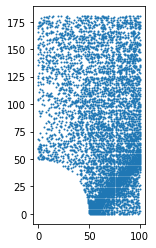

In [4]:
E_true = 70e3
V_true = 0.2 
SY_true = 243.0 

Lambda_true = E_true*V_true / (1+V_true) / (1-2*V_true)
G_true = E_true / (1+V_true) / 2
B_true = Lambda_true + 2/3*G_true

# data preparion.
# attached file for accessing data.
from utility_functions import eval_mu_sig, std, invstd, get_training_data
mu_sig, data_s = get_training_data(ndata=5000, adaptive_sampling=True)

# smapling data. 
fig = plt.figure(figsize=(2,4))
plt.scatter(data_s['x'], data_s['y'], s=1)
plt.show()

In [5]:
# defining normalization factors.
SBAR = np.min([mu_sig[v][1] for v in ['sxx', 'syy', 'szz', 'sxy']])
UBAR = np.min([mu_sig[v][1] for v in ['u', 'v']])
EBAR = np.min([mu_sig[v][1] for v in ['exx', 'eyy', 'exy']])

# Neural network setup

Following the approach proposed in https://arxiv.org/abs/2003.02751, we approximate displacement and stress components $u_x, u_y, \sigma_{xx}, \sigma_{yy}, \sigma_{zz}, \sigma_{xy}$ with nonlinear neural networks as:

$$
\begin{split}
    \hat{u}_x&: (x, y) \mapsto \mathcal{N}_{u_x}(x, y; \mathbf{W}, \mathbf{b}) \\
    \hat{v}_x&: (x, y) \mapsto \mathcal{N}_{v_x}(x, y; \mathbf{W}, \mathbf{b}) \\
    \hat{\sigma}_{xx}&: (x, y) \mapsto \mathcal{N}_{\sigma_{xx}}(x, y; \mathbf{W}, \mathbf{b}) \\
    \hat{\sigma}_{yy}&: (x, y) \mapsto \mathcal{N}_{\sigma_{yy}}(x, y; \mathbf{W}, \mathbf{b}) \\
    \hat{\sigma}_{zz}&: (x, y) \mapsto \mathcal{N}_{\sigma_{zz}}(x, y; \mathbf{W}, \mathbf{b})\\
    \hat{\sigma}_{xy}&: (x, y) \mapsto \mathcal{N}_{\sigma_{xy}}(x, y; \mathbf{W}, \mathbf{b})
\end{split}
$$

Note that due to plastic deformation, the out-of-plane stress $\sigma_{zz}$ is not predefined, and therefore we also approximate it with a neural network.

In [6]:
ActFunc = 'tanh'
hidden_layers = 4*[100]
dtype = 'float64'

# Main inputs.
x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)

# Networks are defined on standard data.
Uxys = sn.Functional("Uxys", [x, y], hidden_layers, ActFunc)
Vxys = sn.Functional("Vxys", [x, y], hidden_layers, ActFunc)

# Denormalization.
Uxy, Vxy = [
    invstd(U, mu_sig[v][0], mu_sig[v][1]) 
    for U, v in 
    zip([Uxys, Vxys], ['u', 'v'])
]

# Networks are defined on standard data.
Sxxs = sn.Functional("Sxxs", [x, y], hidden_layers, ActFunc)
Syys = sn.Functional("Syys", [x, y], hidden_layers, ActFunc)
Szzs = sn.Functional("Szzs", [x, y], hidden_layers, ActFunc)
Sxys = sn.Functional("Sxys", [x, y], hidden_layers, ActFunc)

# Denormalization.
Sxx, Syy, Szz, Sxy = [
    invstd(S, mu_sig[v][0], mu_sig[v][1]) 
    for S, v in 
    zip([Sxxs, Syys, Szzs, Sxys], ['sxx', 'syy', 'szz', 'sxy'])
]

# Defining the "physics"

In [7]:
from sciann.utils.math import diff, sqrt, sign, relu

# Strain measures.
Exx = diff(Uxy, x)
Eyy = diff(Vxy, y)
Exy = (diff(Uxy, y) + diff(Vxy, x)) / 2
Evol = Exx + Eyy

Exxs, Eyys, Exys = [
    std(E, mu_sig[v][0], mu_sig[v][1]) 
    for E, v in 
    zip([Exx, Eyy, Exy], ['exx', 'eyy', 'exy'])
]
Evols = Exxs + Eyys

# Momentum relations.
Lx = diff(Sxx, x) + diff(Sxy, y)
Ly = diff(Sxy, x) + diff(Syy, y)

# Randon initial values for parameters.
lmbd, mu, sy0 = np.random.rand(3)

# Defining parameters for inversion.
lmbd = sn.Parameter(lmbd, inputs=[x, y], name="lambda") * Lambda_true
mu = sn.Parameter(mu, inputs=[x, y], name="mu") * G_true
sy0 = sn.Parameter(sy0, inputs=[x, y], name="sy0") * SY_true

poisson = lmbd / (lmbd + mu) / 2
bulk = lmbd + 2/3*mu

# Deviatoric strain components. 
DExx = Exx - Evol/3 
DEyy = Eyy - Evol/3
DEzz = -Evol/3
DExy = Exy
DEq = sqrt((DExx**2 + DEyy**2 + DEzz**2 + 2*DExy**2) * (2/3))

# Eq. plastic strain.
EPE = relu((3*mu*DEq - sy0) / (3*mu))

# Deviatoric stresses.
Prs = -(Sxx + Syy + Szz)/3
DSxx = Sxx + Prs
DSyy = Syy + Prs
DSzz = Szz + Prs 
DSxy = Sxy
DSq = sqrt((DSxx**2 + DSyy**2 + DSzz**2 + 2*DSxy**2) * 1.5)

# Plastic strain components.
PExx = EPE * DSxx / DSq * 1.5
PEyy = EPE * DSyy / DSq * 1.5
PEzz = EPE * DSzz / DSq * 1.5
PExy = EPE * DSxy / DSq * 1.5

# Yield function.
F = DSq - (sy0)

## Defining the targets and optimization model 

In [8]:
targets = []

# available data.
targets.append(sn.Data(Uxys))
targets.append(sn.Data(Vxys))
targets.append(sn.Data(Sxxs))
targets.append(sn.Data(Syys))
targets.append(sn.Data(Szzs))
targets.append(sn.Data(Sxys))
targets.append(sn.Data(Exxs))
targets.append(sn.Data(Eyys))
targets.append(sn.Data(Exys))

# physics-informed targets.
targets.append(sn.Tie(Prs/SBAR, -(lmbd + mu*2/3)/SBAR*Evol))
targets.append(sn.Tie(DSxx/SBAR, 2*mu/SBAR*(DExx - PExx)))
targets.append(sn.Tie(DSyy/SBAR, 2*mu/SBAR*(DEyy - PEyy)))
targets.append(sn.Tie(DSzz/SBAR, 2*mu/SBAR*(DEzz - PEzz)))
targets.append(sn.Tie(DSxy/SBAR, 2*mu/SBAR*(DExy - PExy)))
targets.append(relu(F/SBAR))
targets.append(sn.Data(Lx/SBAR))
targets.append(sn.Data(Ly/SBAR))

# defining the optimization model. 
model = sn.SciModel(
    inputs=[x, y],
    targets=targets,
    loss_func="mse"
)

# Preparing data and training the model.

In [9]:
targets_data = []
# data driven part.
targets_data.append(data_s['u'])
targets_data.append(data_s['v'])
targets_data.append(data_s['sxx'])
targets_data.append(data_s['syy'])
targets_data.append(data_s['szz'])
targets_data.append(data_s['sxy'])
targets_data.append(data_s['exx'])
targets_data.append(data_s['eyy'])
targets_data.append(data_s['exy'])

# physics-informed part.
targets_data += 8*['zeros']

# training the system.
t = time.time()
history = model.train(
        [data_s['x'], data_s['y']],
        targets_data,
        epochs=10000,
        batch_size=50,
        shuffle=True,
        stop_after=1000,
        verbose=0,
        learning_rate=([0, 100, 500, 1000, 10000], 
                       [0.005, 0.001, 0.0005, 0.0001, 0.00001]),
    )
t = time.time() - t

# to save weights for future re-use:
model.save_weights('trained-model.hdf5')

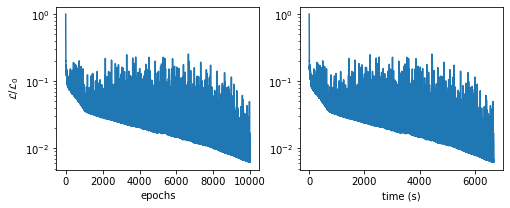

In [10]:
# training history.
fig, ax= plt.subplots(1,2, figsize=(8, 3))
loss_val = history.history['loss']/history.history['loss'][0]
ax[0].semilogy(loss_val)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('$\\mathcal{L}/\\mathcal{L}_0$')
ax[1].semilogy(np.linspace(0, t, loss_val.size), loss_val)
ax[1].set_xlabel('time (s)')
plt.show()

# Post-processing data

Post-processing is performed on a finer "test" mesh. 

In [11]:
from utility_functions import get_test_data

X_plot, Y_plot, nan_ids = get_test_data(200, 400)
input_plot = [X_plot, Y_plot]

lmbd_pred = lmbd.eval(model, [X_plot, Y_plot])
lmbd_pred.reshape(-1,1)[nan_ids] = float('nan')

mu_pred = mu.eval(model, [X_plot, Y_plot])
mu_pred.reshape(-1,1)[nan_ids] = float('nan')

sy0_pred = sy0.eval(model, [X_plot, Y_plot])
sy0_pred.reshape(-1,1)[nan_ids] = float('nan')

Uxy_pred = Uxy.eval(model, [X_plot, Y_plot])
Uxy_pred.reshape(-1,1)[nan_ids] = float('nan')

Vxy_pred = Vxy.eval(model, [X_plot, Y_plot])
Vxy_pred.reshape(-1,1)[nan_ids] = float('nan')

Exx_pred = Exx.eval(model, [X_plot, Y_plot])
Exx_pred.reshape(-1,1)[nan_ids] = float('nan')

Eyy_pred = Eyy.eval(model, [X_plot, Y_plot])
Eyy_pred.reshape(-1,1)[nan_ids] = float('nan')

Exy_pred = Exy.eval(model, [X_plot, Y_plot])
Exy_pred.reshape(-1,1)[nan_ids] = float('nan')

PExx_pred = PExx.eval(model, [X_plot, Y_plot])
PExx_pred.reshape(-1,1)[nan_ids] = float('nan')

PEyy_pred = PEyy.eval(model, [X_plot, Y_plot])
PEyy_pred.reshape(-1,1)[nan_ids] = float('nan')

PExy_pred = PExy.eval(model, [X_plot, Y_plot])
PExy_pred.reshape(-1,1)[nan_ids] = float('nan')

PEzz_pred = PEzz.eval(model, [X_plot, Y_plot])
PEzz_pred.reshape(-1,1)[nan_ids] = float('nan')

EPE_pred = EPE.eval(model, [X_plot, Y_plot])
EPE_pred.reshape(-1,1)[nan_ids] = float('nan')

Sxx_pred = Sxx.eval(model, [X_plot, Y_plot])
Sxx_pred.reshape(-1,1)[nan_ids] = float('nan')

Syy_pred = Syy.eval(model, [X_plot, Y_plot])
Syy_pred.reshape(-1,1)[nan_ids] = float('nan')

Sxy_pred = Sxy.eval(model, [X_plot, Y_plot])
Sxy_pred.reshape(-1,1)[nan_ids] = float('nan')

Szz_pred = Szz.eval(model, [X_plot, Y_plot])
Szz_pred.reshape(-1,1)[nan_ids] = float('nan')

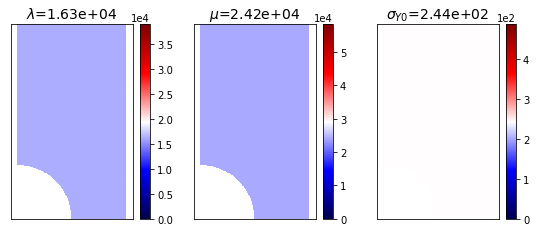

In [12]:
from plotting import custom_pcolor

fig, ax = plt.subplots(1, 3, figsize=(8, 3))
im = custom_pcolor(ax[0], X_plot, Y_plot, lmbd_pred, "$\lambda$={:.2e}".format(np.nanmean(lmbd_pred)), True, vmin=0.0, vmax=2*Lambda_true)
im = custom_pcolor(ax[1], X_plot, Y_plot, mu_pred, "$\mu$={:.2e}".format(np.nanmean(mu_pred)), True, vmin=0.0, vmax=2*G_true)
im = custom_pcolor(ax[2], X_plot, Y_plot, sy0_pred, "$\sigma_{{Y0}}$={:.2e}".format(np.nanmean(sy0_pred)), True, vmin=0.0, vmax=2*SY_true)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
plt.show()

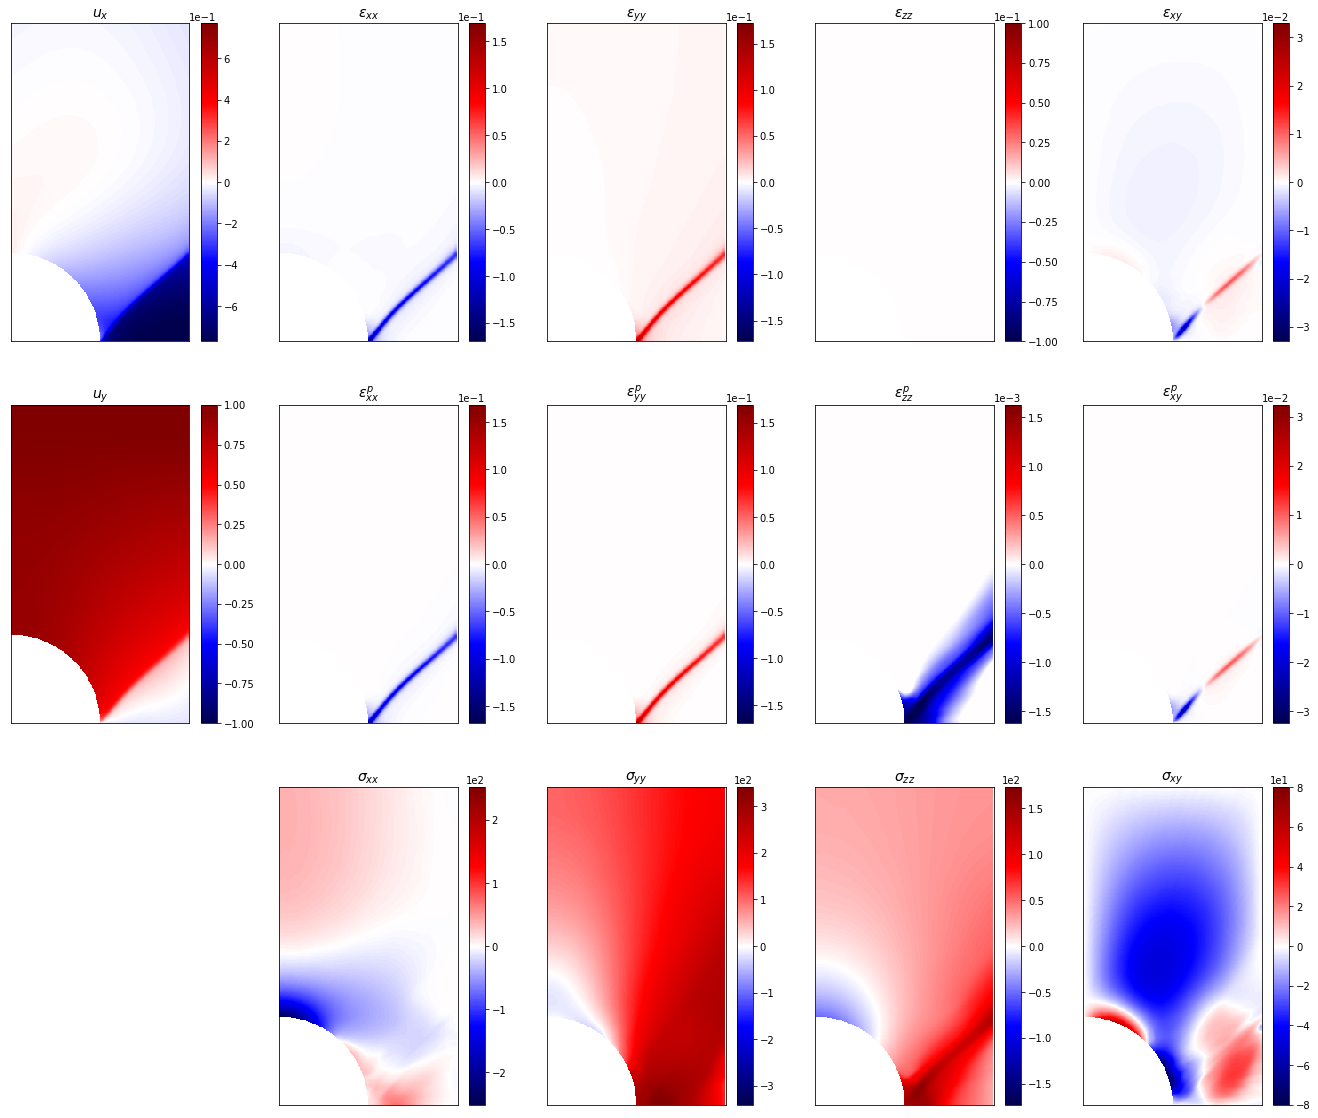

In [13]:

Upred = [Uxy_pred, Vxy_pred]
Epred = [Exx_pred, Eyy_pred, Eyy_pred*0.0, Exy_pred]
PEpred = [PExx_pred, PEyy_pred, PEzz_pred, PExy_pred]
Spred = [Sxx_pred, Syy_pred, Szz_pred, Sxy_pred]

# some bounds to easily compare to true values. 
from utility_functions import get_data_max
data_max = get_data_max()

fig, ax = plt.subplots(3, 5, figsize=(20, 16.7))

im = custom_pcolor(ax[0, 0], X_plot, Y_plot, Upred[0], "$u_x$", True, data_max['u'])
im = custom_pcolor(ax[1, 0], X_plot, Y_plot, Upred[1], "$u_y$", True, data_max['v'])
ax[2, 0].axis('off')

im = custom_pcolor(ax[0, 1], X_plot, Y_plot, Epred[0], "$\\varepsilon_{xx}$", True, data_max['exx'])
im = custom_pcolor(ax[0, 2], X_plot, Y_plot, Epred[1], "$\\varepsilon_{yy}$", True, data_max['eyy'])
im = custom_pcolor(ax[0, 3], X_plot, Y_plot, Epred[2], "$\\varepsilon_{zz}$", True, data_max['ezz'])
im = custom_pcolor(ax[0, 4], X_plot, Y_plot, Epred[3], "$\\varepsilon_{xy}$", True, data_max['exy'])

im = custom_pcolor(ax[1, 1], X_plot, Y_plot, PEpred[0], "$\\varepsilon_{xx}^p$", True, data_max['plxx'])
im = custom_pcolor(ax[1, 2], X_plot, Y_plot, PEpred[1], "$\\varepsilon_{yy}^p$", True, data_max['plyy'])
im = custom_pcolor(ax[1, 3], X_plot, Y_plot, PEpred[2], "$\\varepsilon_{zz}^p$", True, data_max['plzz'])
im = custom_pcolor(ax[1, 4], X_plot, Y_plot, PEpred[3], "$\\varepsilon_{xy}^p$", True, data_max['plxy'])

im = custom_pcolor(ax[2, 1], X_plot, Y_plot, Spred[0], "$\\sigma_{xx}$", True, data_max['sxx'])
im = custom_pcolor(ax[2, 2], X_plot, Y_plot, Spred[1], "$\\sigma_{yy}$", True, data_max['syy'])
im = custom_pcolor(ax[2, 3], X_plot, Y_plot, Spred[2], "$\\sigma_{zz}$", True, data_max['szz'])
im = custom_pcolor(ax[2, 4], X_plot, Y_plot, Spred[3], "$\\sigma_{xy}$", True, data_max['sxy'])

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)